# Parameter Count and Receptive Field

This notebook showcases two features of `PDEquinox`:

1. To count the number of parameters of complex architectures. This allows us to
   investigate how the parameterspace of a network grows based on the number
   hidden channels, layers, etc.
2. The receptive field. Since the architectures of this package are designed to
   operate on discrete fields, this quantity helps assess how many discrete
   steps the networks "see" in each direction and spatial dimension.

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import pdequinox as pdeqx

## Parameter Count

### Conv-Net

Let's first use a feedforward ConvNet in its default configuration. Here, we
only have to define the number of spatial dimension, the number of in-channels,
and the number of out-channels. All are set to one in this example.

The default configuration has 10 hidden layers with 16 hidden channels. As such,
there are a total of 11 convolutions in this network. Two of them map 1->16 or
16->1, the other 9 map 16->16. Each convolution has a kernel size of 3x3 and
adds a bias. Hence, we get

$$
(1*16) * 3 + 16 + 9 * ((16*16) * 3 + 16) + (16 * 1) * 3 + 1 = 7169
$$

In [2]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, key=jax.random.PRNGKey(0))
pdeqx.count_parameters(conv_net)

2024-04-17 09:18:04.815268: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


7169

What happens if we change the number of hidden channels (but keep the hidden
depth of 10)?

-> The number of parameters quadruples!

In [3]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, hidden_channels=32, key=jax.random.PRNGKey(0))
pdeqx.count_parameters(conv_net)

28161

Let's plot this behavior for a range of hidden channels.

We will see that for one order of magnitude increase in hidden channels, the
number of parameters increases by two orders of magnitude.

Text(0, 0.5, 'Number of parameters')

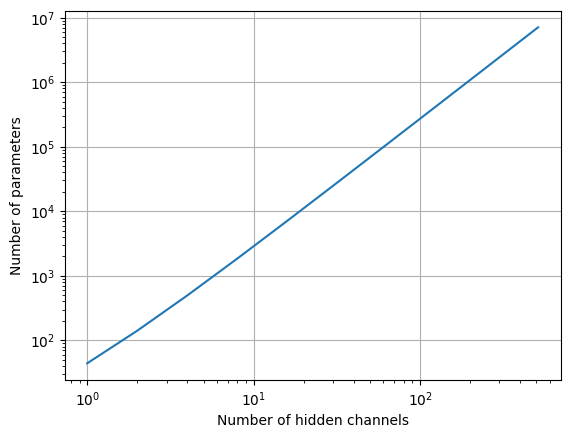

In [4]:
hidden_channels_range = [2**i for i in range(0, 10)]
num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ConvNet(1, 1, 1, hidden_channels=hc, key=jax.random.PRNGKey(0))
    )
    for hc in hidden_channels_range
]
plt.loglog(hidden_channels_range, num_parameters)
plt.grid()
plt.xlabel("Number of hidden channels")
plt.ylabel("Number of parameters")

How does it scale with depth?

-> After an initial stronger phase, it will grow **linearly**

Text(0, 0.5, 'Number of parameters')

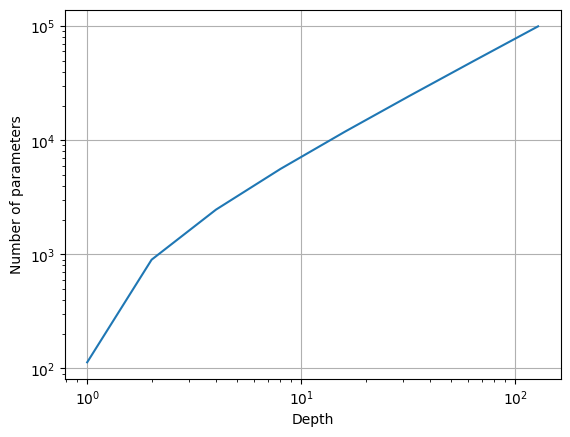

In [5]:
depth_range = [2**i for i in range(0, 8)]
num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ConvNet(
            1, 1, 1, hidden_channels=16, depth=d, key=jax.random.PRNGKey(0)
        )
    )
    for d in depth_range
]
plt.loglog(depth_range, num_parameters)
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Number of parameters")

How does it scale with respect to kernel size?

-> The growth is also **linear**

Text(0, 0.5, 'Number of parameters')

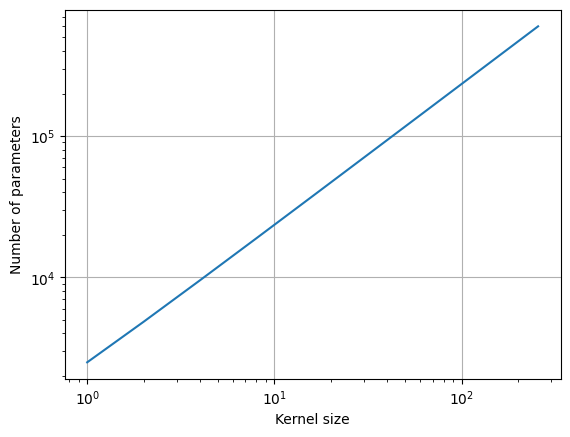

In [6]:
kernel_size_range = [2**i for i in range(0, 9)]

num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ConvNet(
            1, 1, 1, hidden_channels=16, kernel_size=ks, key=jax.random.PRNGKey(0)
        )
    )
    for ks in kernel_size_range
]
plt.loglog(kernel_size_range, num_parameters)
plt.grid()
plt.xlabel("Kernel size")
plt.ylabel("Number of parameters")

How does it scale with respect to the **number of spatial dimensions**? (i.e.,
whether we use 1d, 2d, or 3d convolutions)

Text(0, 0.5, 'Number of parameters')

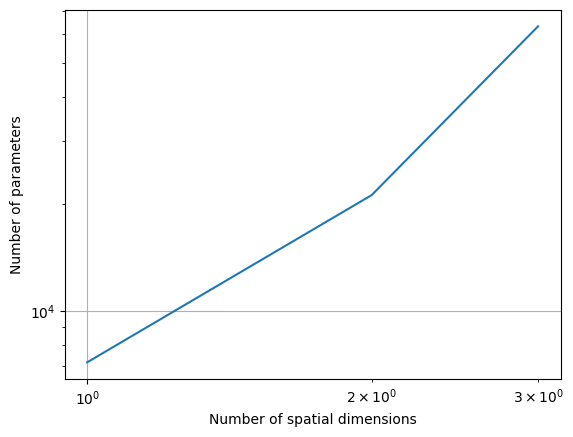

In [7]:
num_spatial_dims_range = [1, 2, 3]

num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ConvNet(d, 1, 1, hidden_channels=16, key=jax.random.PRNGKey(0))
    )
    for d in num_spatial_dims_range
]

plt.loglog(num_spatial_dims_range, num_parameters)
plt.grid()
plt.xlabel("Number of spatial dimensions")
plt.ylabel("Number of parameters")

In general, we observe the following growths:

* Hidden channels: Quadratic
* Depth: Linear
* Kernel size: Linear

Other modifications are:

* A change in the number of input or output channels causes a negligible change
  in the number of parameters (because most of them are due to the dense
  convolutions in the hidden layers)
* Deactivating the bias: will reduce the parameter space slightly

### ResNet

The default configuration of the ResNet has 6 blocks and 32 hidden channels.
Each block does two 3x3 convolutions. It uses linear 1x1 convolutions with no
bias for lifting and projection.

Hence, we expect for the parameter count

$$
(1*32) * 1 + 32 + 6 * ((32*32) * 3 + 32) * 2 + (32 * 1) * 1 + 1 = 37'345
$$

In [8]:
res_net = pdeqx.arch.ClassicResNet(1, 1, 1, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(res_net)

37345

Here, we have to following growths:

* Hidden channels: Quadratic
* Number of blocks: Linear (this is similar to changing the depth for the conv net)
* Kernel size: Linear

By default, the Classic ResNet comes without any normalization. We can activate
it to get a group norm with `num_groups=1` (= layer norm) after each of the two
convolutions in the blocks. Each group norm adds two parameters per channel.

Hence, we add 64 parameters per convolution, 128 parameters per block, and 6*128 =
768 parameters in total.

In total we get 37'345 + 768 = 38'113 parameters.

In [9]:
res_net = pdeqx.arch.ClassicResNet(1, 1, 1, use_norm=True, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(res_net)

38113

The modern ResNet architecture under `pdequinox.nn.ModernResNet` just has the
order of operations in the blocks rearranged, and it activates the group norm
by default. Hence, we expect 38'113 parameters for this architecture as well.

In [10]:
modern_res_net = pdeqx.arch.ModernResNet(1, 1, 1, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(modern_res_net)

38113

### UNet

The default configuration follows the original UNet paper by Ronneberger et al.
(2015) and has 4 levels (of resolution different than the input resolution).

Since with each level, we half the spatial resolution and **double the feature
dimension**, there are increasingly many parameters in the lower levels of the
UNets. This is because the number of parameters for convolutions scales
quadratically with the number of hidden channels.

In [11]:
u_net = pdeqx.arch.ClassicUNet(1, 1, 1, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(u_net)

789089

### FNO

The Fourier Neural Operator uses spectral convolutions. In the default
configuration, it has 32 hidden layers, uses 12 modes for the spectral
convolution, and has 4 blocks. Each block contains one spectral convolution
together with a linear 1x1 bypass convolution. Lifting and projection are linear
1x1 convolutions. Note that the weights associated with the spectral convolution
are complex and therefore saved by two real numbers (real and imaginary part).

As such, we expect the following number of parameters:

$$
(1*32) * 1 + 32 + 4 * ((32*32) * 12 * 2 + (32 * 32) * 1 + 32) + (32 * 1) * 1 + 1 = 15'425

In [12]:
fno = pdeqx.arch.ClassicFNO(1, 1, 1, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(fno)

102625

How does this scale with the number of modes?

-> Linear

Text(0, 0.5, 'Number of parameters')

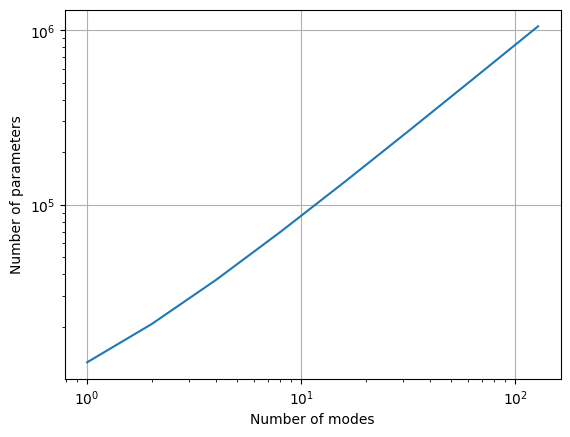

In [13]:
num_modes = [2**i for i in range(0, 7 + 1)]

num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ClassicFNO(1, 1, 1, num_modes=n, key=jax.random.PRNGKey(0))
    )
    for n in num_modes
]

plt.loglog(num_modes, num_parameters)
plt.grid()
plt.xlabel("Number of modes")
plt.ylabel("Number of parameters")

How does it scale with the number of modes in 2d?

-> Quadratic

Text(0, 0.5, 'Number of parameters')

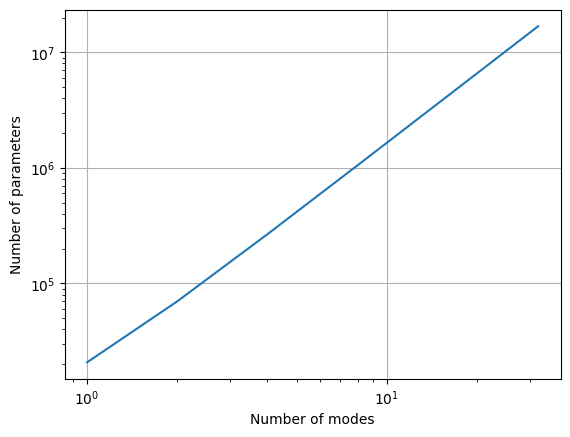

In [14]:
num_modes = [2**i for i in range(0, 5 + 1)]

num_parameters = [
    pdeqx.count_parameters(
        pdeqx.arch.ClassicFNO(2, 1, 1, num_modes=n, key=jax.random.PRNGKey(0))
    )
    for n in num_modes
]

plt.loglog(num_modes, num_parameters)
plt.grid()
plt.xlabel("Number of modes")
plt.ylabel("Number of parameters")

### Dilated ResNet

A dilated ResNet uses multiple stacked convolutions. In the default
configuration, one block consists of the dilation factors 1, 2, 4, 8, 4, 2, 1.
Using a convolution with dilation does not increase the number of parameters.
Hence, using the defaul 32 hidden channels and two blocks. All with active group
normalization, and linear 1x1 convolutions for lifting and projection, we expect
the following number of parameters:

$$
(1*32) * 1 + 32 + 2 * ((32*32) * 3 + 32 + 2 * 32) * 7 + (32 * 1) * 1 + 1 = 44'449
$$

In [15]:
dil_res_net = pdeqx.arch.DilatedResNet(1, 1, 1, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(dil_res_net)

44449

### Multi-Layer Perceptron (MLP)

The MLP is part of `PDEquinox` for completion. Different to the other
convolution-based architectures, it needs to be informed of the spatial
resolution it operates on because internally, it will flatten all spatial
axes and the channel axis into one long vector which is densely connected.

The default configuration has 3 hidden layers with 64 hidden features each. If
we assume an input resolution of 48, the total number of parameters are:

$$
(48*1) * 64 + 64 + 2 * ((64*64) * 1 + 64) + (64 * 48) * 1 + 48 = 14'576
$$

In [16]:
mlp_net = pdeqx.arch.MLP(1, 1, 1, num_points=48, key=jax.random.PRNGKey(0))

pdeqx.count_parameters(mlp_net)

14576

## Receptive Field

The receptive field is denoted as a tuple of tuple of two floats. The outer-most
tuple represents the spatial dimension, the inner-most tuple the direction (down
and up).

For example,

```python
((4, 5), (3, 3))
```

would mean that in the zeroth spatial dimension (="x"), the network sees its
four neighbors in the negative direction (to the left) and five neighbors in the
positive direction (to the right). In the first spatial dimension (="y"), it
sees three neighbors in the negative direction (downward) and three neighbors in
the positive direction (upward).

Conceptually, a receptive field will always be an integer. However, `PDEquinox`
chooses to represent it as a float to allow for representing architectures with
an infinite receptive field.

### Conv-Net

In the default configuration, a conv net has a symmetric field which is
dependent on the depth+1.

In [17]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((11.0, 11.0),)

Increasing the depth, increases the receptive field linearly.

In [18]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, depth=20, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((21.0, 21.0),)

Changing the kernel size, increases the receptive field linearly (based on the
symmetric amount of the kernel).

In [19]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, kernel_size=5, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((22.0, 22.0),)

Changing the number of hidden channels does **not** change the receptive field.

In [20]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, hidden_channels=128, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((11.0, 11.0),)

If we use an even kernel size, the receptive field will be asymmetric. For a
kernel size of two, it will also only be in one direction. Due to the way
even-length convolutions are implemented in JAX, the upward direction is
preferred.

In [21]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, kernel_size=2, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((0.0, 11.0),)

In [22]:
conv_net = pdeqx.arch.ConvNet(1, 1, 1, kernel_size=4, key=jax.random.PRNGKey(0))
conv_net.receptive_field

((11.0, 22.0),)

### ResNet

For the receptive field, a ResNet behaves similarly to a ConvNet. Since each
block in a ResNet has two convolutions, the receptive field grows by two with
each block. Note that in the implementation of `PDEquinox`, lifting and
projection layers are 1x1 convolutions, and hence do not increase the receptive
field.

In [23]:
res_net = pdeqx.arch.ClassicResNet(1, 1, 1, key=jax.random.PRNGKey(0))
res_net.receptive_field

((12.0, 12.0),)

In [24]:
res_net = pdeqx.arch.ClassicResNet(1, 1, 1, num_blocks=12, key=jax.random.PRNGKey(0))
res_net.receptive_field

((24.0, 24.0),)

### UNet

Since UNets reduce the spatial resolution by a factor of two when going down one
level, a 3x3 convolution will now have an effective receptive field of a 5x5
convolution! Another level down, it will be 9x9, then 17x17, etc.

The total receptive field is dominated by the lowest level of the UNet.

In [25]:
u_net = pdeqx.arch.ClassicUNet(1, 1, 1, key=jax.random.PRNGKey(0))
u_net.receptive_field

((137.0, 137.0),)

The growth is exponentially with the number of levels!

Text(0, 0.5, 'Receptive field')

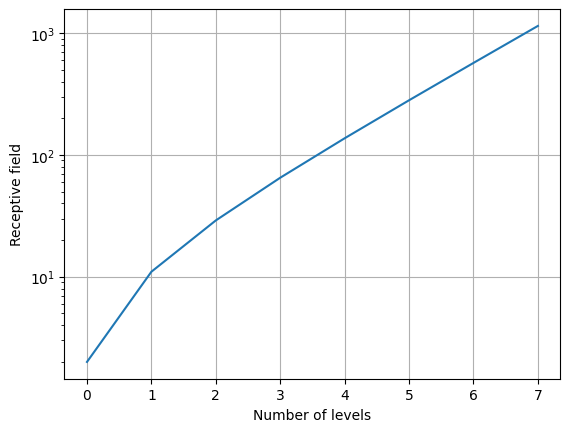

In [26]:
num_levels_range = [0, 1, 2, 3, 4, 5, 6, 7]
receptive_field_per_direction = [
    pdeqx.arch.ClassicUNet(
        1, 1, 1, num_levels=n, hidden_channels=1, key=jax.random.PRNGKey(0)
    ).receptive_field[0][0]
    for n in num_levels_range
]

plt.semilogy(num_levels_range, receptive_field_per_direction)
plt.grid()
plt.xlabel("Number of levels")
plt.ylabel("Receptive field")

### FNO

The receptive field of an FNO is infinite. This is because the spectral
convolution is a global operation.

In [27]:
fno = pdeqx.arch.ClassicFNO(1, 1, 1, key=jax.random.PRNGKey(0))
fno.receptive_field

((inf, inf),)

### Dilated ResNet

Using a range of dilation factors in a block, the receptive field grows
exponentially with the number of convolutions in the block.

In [28]:
dil_res_net = pdeqx.arch.DilatedResNet(1, 1, 1, key=jax.random.PRNGKey(0))
dil_res_net.receptive_field

((44.0, 44.0),)

In [29]:
dil_res_net = pdeqx.arch.DilatedResNet(
    1, 1, 1, dilation_rates=[1, 2, 1], key=jax.random.PRNGKey(0)
)
dil_res_net.receptive_field

((8.0, 8.0),)

In [30]:
dil_res_net = pdeqx.arch.DilatedResNet(
    1, 1, 1, dilation_rates=[1, 2, 4, 2, 1], key=jax.random.PRNGKey(0)
)
dil_res_net.receptive_field

((20.0, 20.0),)

### Multi-Layer Perceptron (MLP)

Since the MLP is densely connected also between the spatial dimensions, the
receptive field is that of the input resolution.

In [31]:
mlp_net = pdeqx.arch.MLP(1, 1, 1, num_points=48, key=jax.random.PRNGKey(0))
mlp_net.receptive_field

((48, 48),)

In [32]:
mlp_net = pdeqx.arch.MLP(1, 1, 1, num_points=103, key=jax.random.PRNGKey(0))
mlp_net.receptive_field

((103, 103),)